In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bearing-health/97.mat
/kaggle/input/bearing-health/130.mat
/kaggle/input/bearing-health/105.mat
/kaggle/input/bearing-health/118.mat


In [3]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os


In [4]:
# Function to load and plot signal from a .mat file
def load_and_plot(filepath, key, title):
    data = loadmat(filepath)
    signal = data[key].ravel()
    plt.figure(figsize=(12, 4))
    plt.plot(signal[:3000])
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    return signal


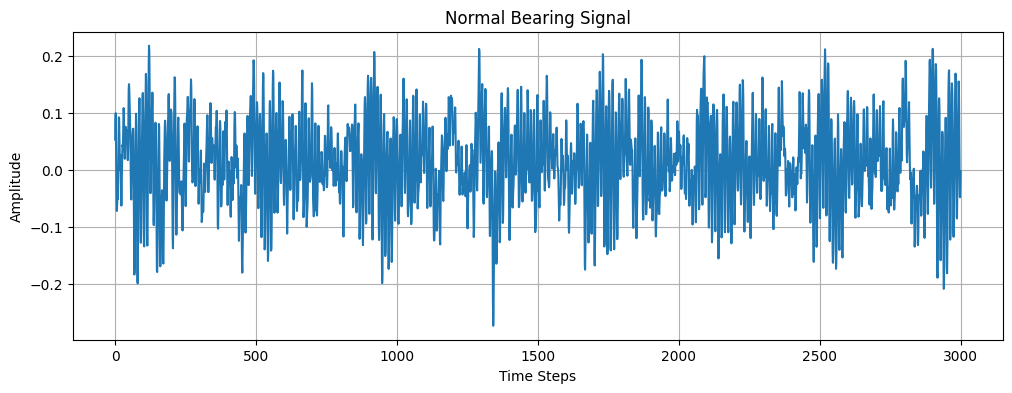

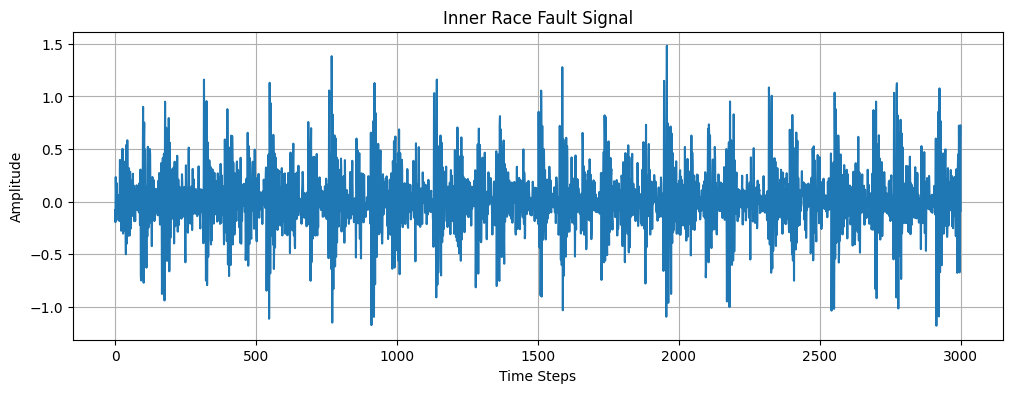

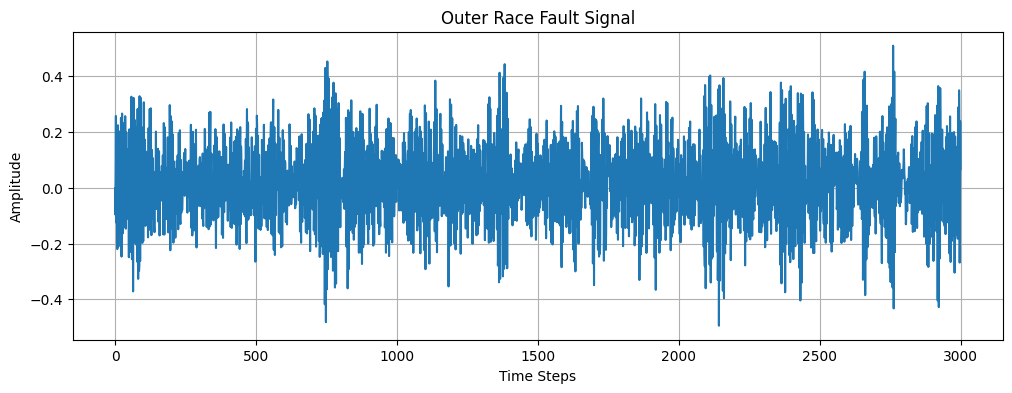

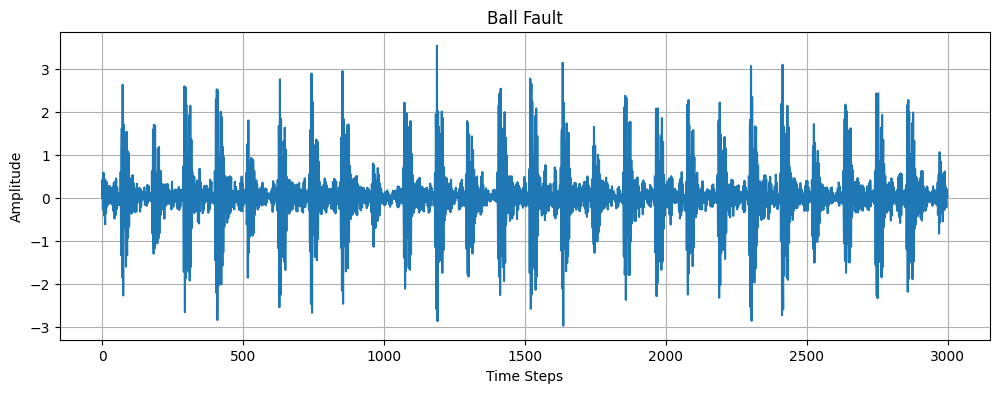

dict_keys(['__header__', '__version__', '__globals__', 'X130_DE_time', 'X130_FE_time', 'X130_BA_time', 'X130RPM'])


In [5]:
# Normal bearing (97.mat)
signal_normal = load_and_plot("/kaggle/input/bearing-health/97.mat", "X097_DE_time", "Normal Bearing Signal")

# Inner race fault (105.mat)
signal_inner = load_and_plot("/kaggle/input/bearing-health/105.mat", "X105_DE_time", "Inner Race Fault Signal")

# Outer race fault (118.mat)
signal_outer = load_and_plot("/kaggle/input/bearing-health/118.mat", "X118_DE_time", "Outer Race Fault Signal")
ball_data = load_and_plot("/kaggle/input/bearing-health/130.mat", "X130_DE_time", "Ball Fault")


#  Ball fault(e.g., 130.mat)
# Check the key name first
ball_data = loadmat("/kaggle/input/bearing-health/130.mat")
print(ball_data.keys())  # Check for something like 'X130_DE_time'



In [6]:
def summarize_signal(filepath, key):
    data = loadmat(filepath)
    sig = data[key].ravel()
    print(f"{filepath}: Samples = {len(sig)}, Max = {np.max(sig):.2f}, Min = {np.min(sig):.2f}, Std Dev = {np.std(sig):.2f}")

summarize_signal("/kaggle/input/bearing-health/97.mat", "X097_DE_time")
summarize_signal("/kaggle/input/bearing-health/105.mat", "X105_DE_time")
summarize_signal("/kaggle/input/bearing-health/118.mat", "X118_DE_time")
summarize_signal("/kaggle/input/bearing-health/130.mat", "X130_DE_time") 


/kaggle/input/bearing-health/97.mat: Samples = 243938, Max = 0.31, Min = -0.29, Std Dev = 0.07
/kaggle/input/bearing-health/105.mat: Samples = 121265, Max = 1.74, Min = -1.38, Std Dev = 0.29
/kaggle/input/bearing-health/118.mat: Samples = 122571, Max = 0.60, Min = -0.61, Std Dev = 0.14
/kaggle/input/bearing-health/130.mat: Samples = 121991, Max = 3.63, Min = -3.41, Std Dev = 0.67


In [7]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [8]:
# Map each file to its label
file_map = {
    '/kaggle/input/bearing-health/97.mat': ('X097_DE_time', 0),    # Normal
    '/kaggle/input/bearing-health/105.mat': ('X105_DE_time', 1),   # Inner Race
    '/kaggle/input/bearing-health/118.mat': ('X118_DE_time', 2),   # Outer Race
    '/kaggle/input/bearing-health/130.mat': ('X130_DE_time', 3),   # Ball Fault (or use another if different)
}


In [9]:
def segment_signal(signal, fs=12000, window_sec=5):
    win_len = fs * window_sec
    segments = []
    for start in range(0, len(signal), win_len):
        chunk = signal[start:start+win_len]
        if len(chunk) == win_len:
            segments.append(chunk)
    return segments

def segment_to_spectrogram(segment, fs=12000, out_shape=(128, 128)):
    f, t, Sxx = spectrogram(segment, fs, nperseg=256, noverlap=128)
    Sxx_db = 10 * np.log10(Sxx + 1e-8)  # Convert to dB scale
    # Resize/pad to out_shape
    out = np.zeros(out_shape)
    h, w = min(Sxx_db.shape[0], out_shape[0]), min(Sxx_db.shape[1], out_shape[1])
    out[:h, :w] = Sxx_db[:h, :w]
    return out


In [14]:
X = []
y = []

for filename, (key, label) in tqdm(file_map.items()):
    print(f"Processing {filename}...")
    data = loadmat(filename)
    signal = data[key].ravel()

    segments = segment_signal(signal)
    for seg in segments:
        spec = segment_to_spectrogram(seg)
        X.append(spec)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Reshape for CNN: (samples, height, width, channels)
X = X[..., np.newaxis]
print("Final data shape:", X.shape, y.shape)


100%|██████████| 4/4 [00:00<00:00, 113.76it/s]

Processing /kaggle/input/bearing-health/97.mat...
Processing /kaggle/input/bearing-health/105.mat...
Processing /kaggle/input/bearing-health/118.mat...
Processing /kaggle/input/bearing-health/130.mat...
Final data shape: (10, 128, 128, 1) (10,)


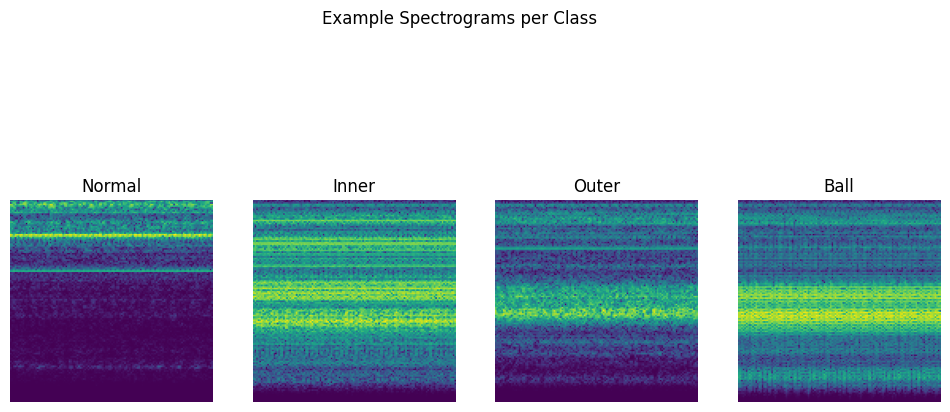

In [15]:
# Check one spectrogram per class
class_names = ['Normal', 'Inner', 'Outer', 'Ball']
plt.figure(figsize=(12, 6))
for class_id in range(4):
    idx = np.where(y == class_id)[0][0]
    plt.subplot(1, 4, class_id+1)
    plt.imshow(X[idx].squeeze(), cmap='viridis')
    plt.title(class_names[class_id])
    plt.axis('off')
plt.suptitle("Example Spectrograms per Class")
plt.show()


In [16]:
# Optional: shuffle dataset
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Optional: save to file
np.savez_compressed("bearing_data.npz", X=X, y=y)
